In [208]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [71]:
with open('../inputs/20_demo.txt', 'r') as f:
    demo_input = f.readlines()
with open('../inputs/20.txt', 'r') as f:
    real_input = f.readlines()

In [16]:
def parse_fragments(lines):
    tile_d = {}
    tile_re = re.compile(r'Tile #?(\d+):')
    tile_no = 0
    data = []
    
    for l in range(len(lines)+1):
        
        if l == len(lines) or lines[l].strip() == "":
            tile_d[tile_no] = data
            continue
            
        elif 'Tile' in lines[l]:
            matches = tile_re.search(lines[l].strip())
            if matches is None:
                print('Error, failed match!', matches)
                break
            tile_no = int(matches.group(1))
            data = []
            
        else:
            data.append([1 if c == '#' else 0 for c in lines[l].strip()])
    
    return tile_d

In [72]:
parsed_data = parse_fragments(demo_input)
real_parsed_data = parse_fragments(real_input)

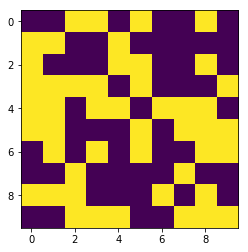

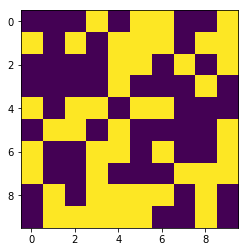

In [33]:
# Try a rotation
piece = list(parsed_data.values())[0]

plt.figure(1)
plt.imshow(piece)
plt.show()

piece_90 = np.rot90(piece)

plt.figure(2)
plt.imshow(piece_90)
plt.show()

piece_180 = np.rot90(piece_90)
piece_270 = np.rot90(piece_180)

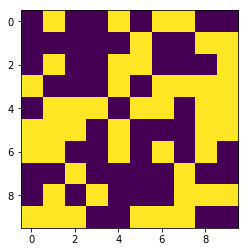

In [34]:
# Try reflections
rpiece = np.fliplr(piece)

plt.figure(3)
plt.imshow(rpiece)
plt.show()

In [36]:
def permute_piece(piece):
    return [
        piece,
        np.rot90(piece),
        np.rot90(np.rot90(piece)),
        np.rot90(np.rot90(np.rot90(piece))),
        np.fliplr(piece),
        np.rot90(np.fliplr(piece)),
        np.rot90(np.rot90(np.fliplr(piece))),
        np.rot90(np.rot90(np.rot90(np.fliplr(piece))))
    ]

In [41]:
print(np.array(rpiece[0]))
print(np.array(rpiece[-1]))
print(np.array(rpiece)[:,0])
print(np.array(rpiece)[:,-1])

[0 1 0 0 1 0 1 1 0 0]
[1 1 1 0 0 1 1 1 0 0]
[0 0 0 1 0 1 1 0 0 1]
[0 1 1 1 1 1 0 0 1 0]


In [42]:
def get_edges(pieces):
    edges = []
    for piece in pieces:
        edges.append(np.array(piece)[0])
        edges.append(np.array(piece)[-1])
        edges.append(np.array(piece)[:,0])
        edges.append(np.array(piece)[:,-1])
    return edges

In [44]:
get_edges([rpiece])

[array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0]),
 array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1]),
 array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0])]

In [65]:
def package_pieces(p):
    d = {}
    for k in p.keys():
        d[k] = {
            'permutations': permute_piece(p[k]),
            'matches': set(),
        }
        d[k]['edges'] = get_edges(d[k]['permutations'])
    return d

In [73]:
ppieces = package_pieces(parsed_data)
rpieces = package_pieces(real_parsed_data)

In [75]:
def match_edges(ppd):
    for x in ppd.keys():
        for y in ppd.keys():
            if x == y:
                continue
            for edge_x in ppd[x]['edges']:
                for edge_y in ppd[y]['edges']:
                    if np.array_equal(edge_x, edge_y):
                        ppd[x]['matches'].add(y)
                        ppd[y]['matches'].add(x)

In [77]:
match_edges(ppieces)

In [78]:
match_edges(rpieces)

In [79]:
for p in ppieces.keys():
    print('{}: {}'.format(p, ppieces[p]['matches']))

2311: {1427, 3079, 1951}
1951: {2729, 2311}
1171: {1489, 2473}
1427: {1489, 2729, 2473, 2311}
1489: {1171, 1427, 2971}
2473: {1171, 1427, 3079}
2971: {1489, 2729}
2729: {1427, 2971, 1951}
3079: {2473, 2311}


In [84]:
prod = 1
for p in rpieces.keys():
    if len(rpieces[p]['matches']) == 2:
        print('{}: {}'.format(p, rpieces[p]['matches']))
        prod *= p
        print(p, prod)

3539: {3137, 1987}
3539 3539
1439: {2417, 3461}
1439 5092621
1571: {1069, 1759}
1571 8000507591
3803: {2633, 3347}
3803 30425930368573


In [85]:
prod

30425930368573

# Here comes part 2!

In [324]:
def stitch(pieces):
    big_dim = int(len(pieces.keys())**0.5)
    small_dim = len(pieces[list(pieces.keys())[0]]['permutations'][0]) # Usually 10
    dim = big_dim * small_dim
    master = np.zeros((dim, dim), int)
    minor = np.zeros((big_dim, big_dim), int)
    used = []
    
    # Sort by location
    corners = []
    edges = []
    middle = []
    
    def _try_removal(x):
        try:
            corners.remove(x)
        except:
            pass
        try:
            edges.remove(x)
        except:
            pass
        try:
            middle.remove(x)
        except:
            pass
    
    
    for piece in pieces:
        if len(pieces[piece]['matches']) == 2:
            corners.append(piece)
        elif len(pieces[piece]['matches']) == 3:
            edges.append(piece)
        else:
            middle.append(piece)
#     print(corners)
#     print(edges)
#     print(middle)

    # Top left piece
    good_orientation = None
    corner = corners[0]
    corners.remove(corner)
    minor[0,0] = corner
    used.append(corner)
    suggested_next = set()
    for perm in pieces[corner]['permutations']:
        right_edge = np.array(perm)[:,-1]
        bottom_edge = np.array(perm)[-1,:]
        good_edges = 0
        for edge_piece in edges:
            for edge in pieces[edge_piece]['edges']:
                if np.array_equal(edge, bottom_edge):
                    good_edges += 1
                    suggested_next.add(edge_piece)
                elif np.array_equal(edge, right_edge):
                    good_edges += 1
                    suggested_next.add(edge_piece)
        if good_edges == 8:
            master[0:small_dim, 0:small_dim] = perm
    
#     print(suggested_next)

    # Rightwards
    for y in range(0,big_dim):
        for x in range(1,big_dim):
            right_edge = master[small_dim*y:small_dim*(y+1), small_dim*x-1]
            chosen_perm = None
            for p in suggested_next:
                if p in used:
                    continue
                for perm in pieces[p]['permutations']:
                    left_edge = np.array(perm)[:,0]
                    if np.array_equal(left_edge, right_edge):
                        minor[y,x] = p
                        used.append(p)
                        chosen_perm = perm
            if chosen_perm is None:
                if y != 0 and y != big_dim-1 and x != big_dim-1:
                    for p in middle:
                        if p in used:
                            continue
                        for perm in pieces[p]['permutations']:
                            left_edge = np.array(perm)[:,0]
                            if np.array_equal(left_edge, right_edge):
                                minor[y,x] = p
                                used.append(p)
                                chosen_perm = perm
                elif y == big_dim-1 and x != big_dim-1:
                    for p in edges:
                        if p in used:
                            continue
                        for perm in pieces[p]['permutations']:
                            left_edge = np.array(perm)[:,0]
                            if np.array_equal(left_edge, right_edge):
                                minor[y,x] = p
                                used.append(p)
                                chosen_perm = perm
                else:
                    for p in corners:
                        if p in used:
                            continue
                        for perm in pieces[p]['permutations']:
                            left_edge = np.array(perm)[:,0]
                            if np.array_equal(left_edge, right_edge):
                                minor[y,x] = p
                                used.append(p)
                                chosen_perm = perm
                if chosen_perm is None: # Last resort. :(
                    for p in pieces.keys():
                        if p in used:
                            continue
                        for perm in pieces[p]['permutations']:
                            left_edge = np.array(perm)[:,0]
                            if np.array_equal(left_edge, right_edge):
                                minor[y,x] = p
                                used.append(p)
                                chosen_perm = perm
                    
            try:
                master[small_dim*y:small_dim*(y+1), small_dim*x:small_dim*(x+1)] = chosen_perm
            except:
                print(f'x: {x}, y: {y}, minor: {minor}')
            
            try:
                suggested_next.remove(minor[y,x])
            except:
                _try_removal(minor[y,x])

            # Find next suggested
            if x == big_dim-2 and (y == 0 or y == big_dim-1): # Search corner pieces
                right_edge = master[small_dim*y:small_dim*(y+1), small_dim*(x+1)-1]
                for corner_piece in corners:
                    for edge in pieces[corner_piece]['edges']:
                        if np.array_equal(edge, right_edge) and not corner_piece in used:
                            suggested_next.add(corner_piece)
            elif (y == 0 or y == big_dim-1) and x != big_dim-1: # Search edge pieces
                for edge_piece in edges:
                    for edge in pieces[edge_piece]['edges']:
                        if np.array_equal(edge, right_edge) and not edge_piece in used:
                            suggested_next.add(edge_piece)
        
        # Work on the one below...
        if y != big_dim-1:
            bottom_edge = master[small_dim*(y+1)-1, :small_dim]
            chosen_perm = None
            for p in suggested_next: # Just get the first one...
                for perm in pieces[p]['permutations']:
                    top_edge = np.array(perm)[0,:]
                    if np.array_equal(top_edge, bottom_edge):
                        minor[y+1, 0] = p
                        used.append(p)
                        chosen_perm = perm
            suggested_next.clear()
            _try_removal(minor[y+1, 0])
            master[small_dim*(y+1):small_dim*(y+2), :small_dim] = chosen_perm
            
            # Find next suggested
            bottom_edge = master[small_dim*(y+2)-1, :small_dim]
            right_edge = master[small_dim*(y+1):small_dim*(y+2), small_dim-1]
            
            if y+2 == big_dim-1: # Next is a corner/edge
                # Search corners on bottom edge
                for corner_piece in corners:
                    for perm in pieces[corner_piece]['permutations']:
                        top_edge = np.array(perm)[0,:]
                        if np.array_equal(top_edge, bottom_edge):
                            suggested_next.add(corner_piece)
            if y == big_dim-1:
                for edge_piece in edges:
                    for perm in pieces[edge_piece]['permutations']:
                        left_edge = np.array(perm)[:,0]
                        if np.array_equal(left_edge, right_edge):
                            suggested_next.add(edge_piece)
            if y+1 < big_dim-1:
                for edge_piece in edges:
                    for perm in pieces[edge_piece]['permutations']:
                        top_edge = np.array(perm)[0,:]
                        if np.array_equal(top_edge, bottom_edge):
                            suggested_next.add(edge_piece)
            
            if y+1 < big_dim-1:
                for mid_piece in middle:
                    for perm in pieces[mid_piece]['permutations']:
                        left_edge = np.array(perm)[:,0]
                        if np.array_equal(left_edge, right_edge):
                            suggested_next.add(edge_piece)
                            
    return master, minor

<IPython.core.display.Javascript object>


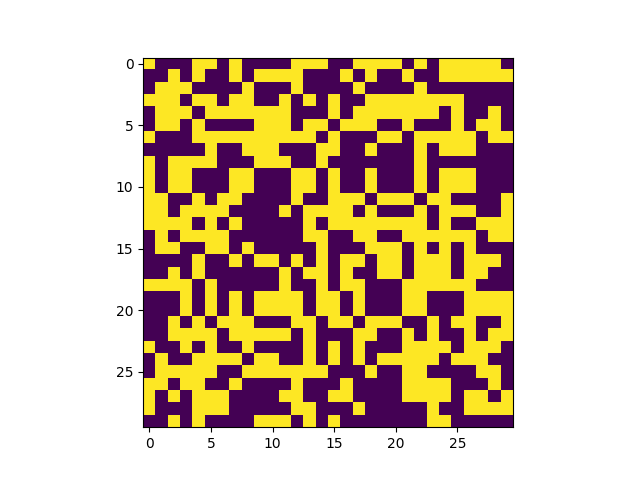

[[1951 2311 3079]
 [2729 1427 2473]
 [2971 1489 1171]]


In [325]:
master, minor = stitch(ppieces)
plt.figure(3)
plt.imshow(master)
plt.show()
print(minor)

x: 1, y: 0, minor: [[3539 3137    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]
x: 2, y: 0, minor: [[3539 3137 2341    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0

 [   0    0    0    0    0    0    0    0    0    0    0    0]]
x: 5, y: 2, minor: [[3539 3137 2341 1879 2213 2087 2803 1373 1913 2719 1069 1571]
 [1987 3413 3947 1973 1283 2293 3533 2039 3691 2843 2851 1759]
 [3671 2579 2029 1489 3769 3191    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]
x: 6, y: 2, minor: [[3539 3137 2341 1879 2213 2087 2803 1373 1913 2719 1069 1571]
 [1987 3413 3947 1973 1283 2293 3533 2039 3691 2843 2851 1759]
 [3671 2579 202

 [   0    0    0    0    0    0    0    0    0    0    0    0]]
x: 7, y: 6, minor: [[3539 3137 2341 1879 2213 2087 2803 1373 1913 2719 1069 1571]
 [1987 3413 3947 1973 1283 2293 3533 2039 3691 2843 2851 1759]
 [3671 2579 2029 1489 3769 3191 2111 1289 1223 2437 3319 1811]
 [2399 3547 1303 2957 1097 3643 1451 1367 3847 3881 1297 3697]
 [3019 1741 1583 2939 1559 1697 2927 1481 1187 1873 2003 2161]
 [3943 3821 1249 2467 1301 2791 2693 1667 3251 2297 1531 1319]
 [3761 2857 2389 1049 2017 1009 1543 1117    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]
x: 8, y: 6, minor: [[3539 3137 2341 1879 2213 2087 2803 1373 1913 2719 1069 1571]
 [1987 3413 3947 1973 1283 2293 3533 2039 3691 2843 2851 1759]
 [3671 2579 202

<IPython.core.display.Javascript object>


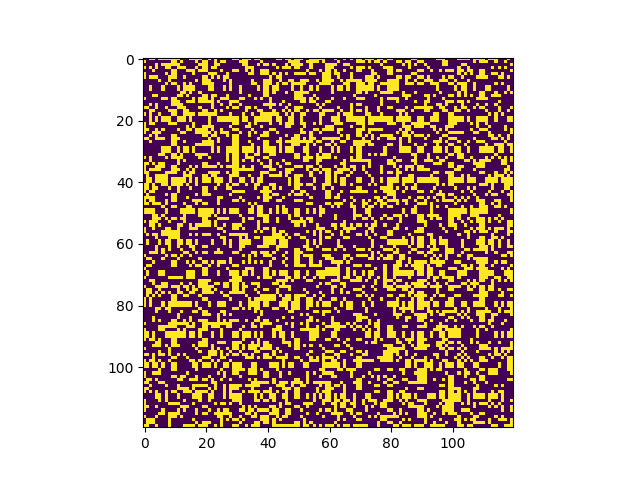

[[3539 3137 2341 1879 2213 2087 2803 1373 1913 2719 1069 1571]
 [1987 3413 3947 1973 1283 2293 3533 2039 3691 2843 2851 1759]
 [3671 2579 2029 1489 3769 3191 2111 1289 1223 2437 3319 1811]
 [2399 3547 1303 2957 1097 3643 1451 1367 3847 3881 1297 3697]
 [3019 1741 1583 2939 1559 1697 2927 1481 1187 1873 2003 2161]
 [3943 3821 1249 2467 1301 2791 2693 1667 3251 2297 1531 1319]
 [3761 2857 2389 1049 2017 1009 1543 1117 2357 1423 2063 3929]
 [1777 2459 2011 3701 1511 1193 1433 1621 2897 3559 1163 3323]
 [1213 1789 2677 1993 3491 2473 3557 1951 2699 2143 3853 1753]
 [2083 1051 3359 2539 1103 3527 2887 2861 3011 1471 2423 1399]
 [3347 3167 1181 2687 1597 2113 3469 3581 2089 3463 3511 3461]
 [3803 2633 2243 3911 2333 3391 3931 3331 3229 3593 2417 1439]]


In [319]:
rmaster, rminor = stitch(rpieces)
plt.figure(4)
plt.imshow(rmaster)
plt.show()
print(rminor)

In [326]:
def trim_major(im):
    n_pieces = len(im) // 10
    for i in range(0, n_pieces):
        im = np.delete(im, 10*(n_pieces-i-1), 0)
        im = np.delete(im, 10*(n_pieces-i-1)-1, 0)
        im = np.delete(im, 10*(n_pieces-i-1), 1)
        im = np.delete(im, 10*(n_pieces-i-1)-1, 1)
    return im

<IPython.core.display.Javascript object>


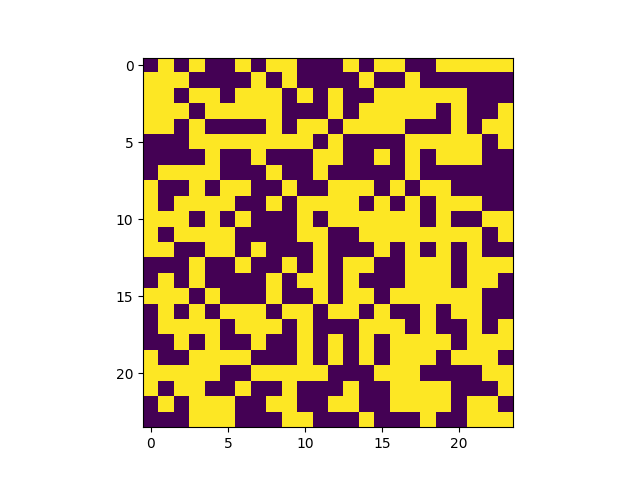

[[1951 2311 3079]
 [2729 1427 2473]
 [2971 1489 1171]]


In [327]:
trimmed_master = trim_major(master)
plt.figure(5)
plt.imshow(trimmed_master)
plt.show()
print(minor)

<IPython.core.display.Javascript object>


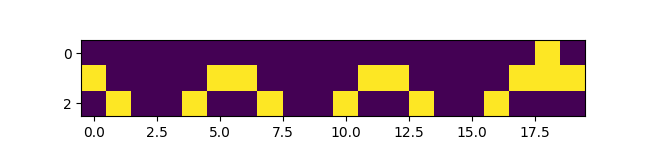

In [261]:
sea_monster = np.array([
 [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,1,0],
 [1,0,0,0,0, 1,1,0,0,0, 0,1,1,0,0, 0,0,1,1,1],
 [0,1,0,0,1, 0,0,1,0,0, 1,0,0,1,0, 0,1,0,0,0],
])
plt.figure(6)
plt.imshow(sea_monster)
plt.show()

In [328]:
def seamonster_at(tmaster, x, y):
    for xi in range(0,20):
        for yi in range(0,3):
            if sea_monster[yi,xi]:
                if not tmaster[y+yi,x+xi]:
                    return False
    for xi in range(0,20):
        for yi in range(0,3):
            if sea_monster[yi,xi]:
                tmaster[y+yi,x+xi] = 2
                    
    return True

In [329]:
seamonster_at(sea_monster, 0,0)

True

In [330]:
def search_for_seamonster(tmaster):
    count = 0
    state = 0
    while count == 0:
        for x in range(len(tmaster[0])-len(sea_monster[0])):
            for y in range(len(tmaster)-len(sea_monster)):
                if seamonster_at(tmaster, x, y):
                    count += 1
        if count == 0:
            tmaster = np.rot90(tmaster)
            state += 1
            if state == 4:
                tmaster = np.fliplr(tmaster)
            if state == 8:
                print('Monster not found')
                return
    

In [331]:
tmaster = trimmed_master[:]

In [332]:
search_for_seamonster(tmaster)

<IPython.core.display.Javascript object>


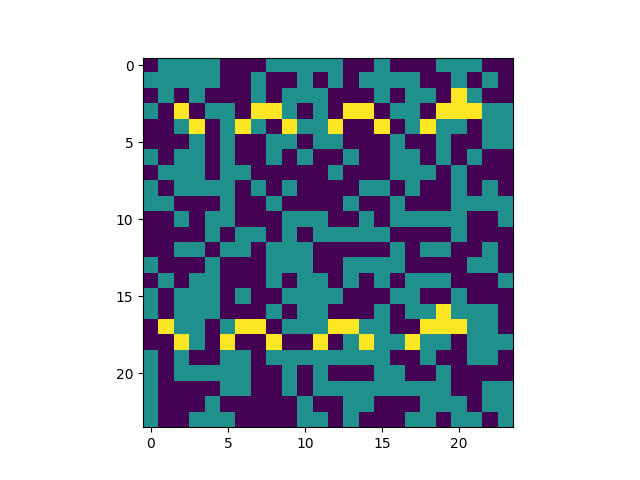

In [333]:
plt.figure(7)
plt.imshow(np.transpose(tmaster))
plt.show()

<IPython.core.display.Javascript object>


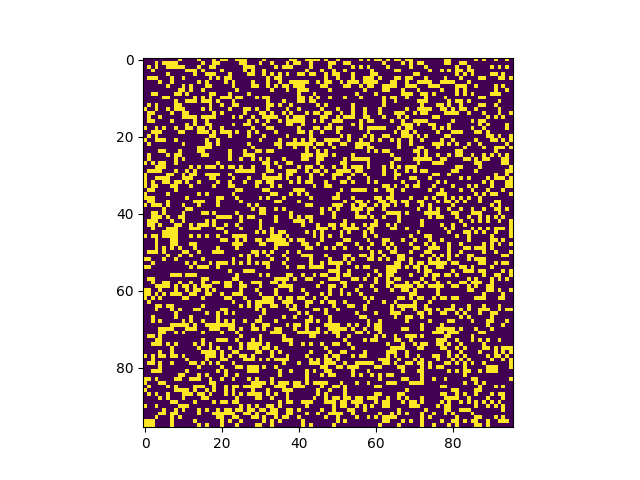

In [335]:
trimmed_rmaster = trim_major(rmaster)
plt.figure(8)
plt.imshow(trimmed_rmaster)
plt.show()

trmaster = trimmed_rmaster[:]
search_for_seamonster(trmaster)

<IPython.core.display.Javascript object>


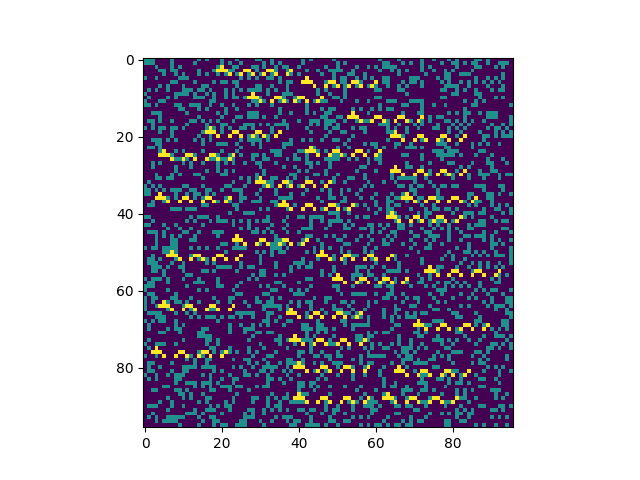

In [338]:
plt.figure(9)
plt.imshow(np.flipud(trmaster))
plt.show()

In [337]:
sum(sum(trmaster == 1))

2453

In [304]:
sum(sum(tmaster == 1))

273